In [1]:
import torch  
from torch import nn
import sys
sys.path.append('../') 
import utils as d2l

## 一、定义一个可视化注意力权重的函数show_heatmaps
**show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),  cmap='Reds')**
- matrices的形状是(要显示的行数,要显示的列数,查询的数目,键的数目)

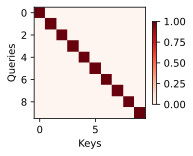

In [4]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))  
d2l.show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 二、Nadaraya-Watson 核回归

### 1.Create data

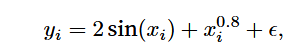

In [5]:
n_train = 50 # 训练样本数  
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本

In [9]:
def f(x):  
    return 2 * torch.sin(x) + x**0.8  
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,)) # 训练样本的输出  
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出  
n_test = len(x_test) # 测试样本数  

下面的函数将绘制所有的训练样本(样本由圆圈表示),不带噪声项的真实数据生成函数f(标记为“Truth”),  以及学习得到的预测函数(标记为“Pred”)。

In [10]:
def plot_kernel_reg(y_hat):  
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],  xlim=[0, 5], ylim=[-1, 5])  
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

注意力汇聚通式：$$f(x)=\sum_{i=1}^n\alpha(x,x_i)y_i$$

### 2.非参数注意力汇聚

$$f(x)=\sum_{i=1}^n\frac{K(x-x_i)}{\sum_{j=1}^nK(x-x_j)}y_i$$

### 3.带参数注意力汇聚

In [15]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [16]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

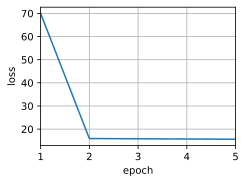

In [17]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

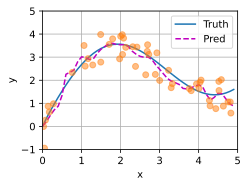

In [19]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

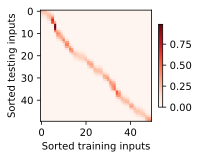

In [20]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')